# Visualising Causal Test Results

## Overview

This tutorial provides users with minimal Python code to visualise the outputs of their causal test results in a simple but intuitive manner. 

**Note**: this approach and provided code depends strongly on the structure and size of the user's directed acyclic graph (DAG) and, therefore, an element of fine-tuning will be required.

In [1]:
import pydot # you may need to run: !pip install pydot if necessary
import networkx as nx # !pip install networkx --upgrade
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from matplotlib.lines import Line2D
import os
import json
import networkx as nx
import pydot
from pathlib import Path

In [2]:
from causal_testing.specification.causal_dag import CausalDAG

def read_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

# Jupyter-friendly: start from current working directory
base_dir = Path(os.getcwd())  
directory = base_dir / ".." / "vaccinating_elderly" 

causal_tests_results = read_json_file(directory / "causal_test_results.json")

dag = CausalDAG(str(directory / "dag.dot"))

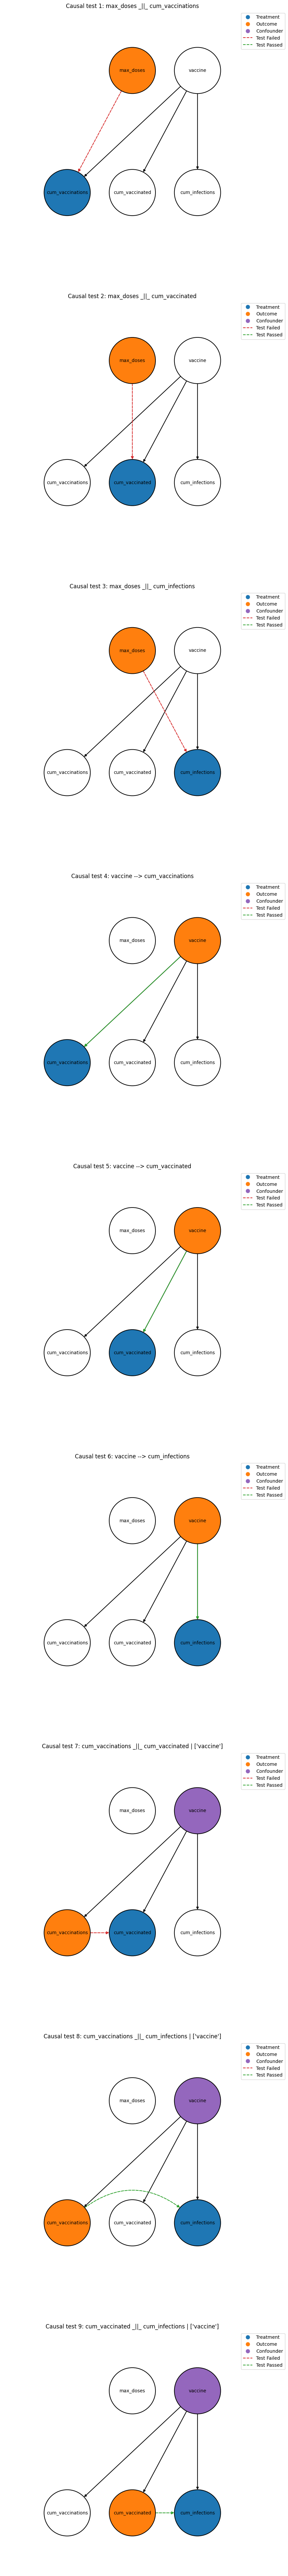

In [3]:
def draw_dag(dag, treatment_node, outcome_node, confounder_node, title, edge_colours, connection_style, ax):
    """
    Draw a Directed Acyclic Graph (DAG) with specified attributes.

    Parameters:
        dag (networkx.DiGraph): The DAG to be drawn.
        treatment_node (str): The treatment node in the DAG.
        outcome_node (str): The outcome node in the DAG.
        confounder_node (str): The confounder node in the DAG.
        title (str): Title of the plot.
        edge_colours (list): List of edge colors.
        connection_style (str): Style of connections between nodes.
        ax (matplotlib.axes.Axes): Axes to draw the plot on.
    """
    # Add layer information to nodes for multipartite layout
    for layer, nodes in enumerate(sorted(nx.topological_generations(dag))):
        for node in nodes:
            dag.nodes[node]["layer"] = layer

    # Compute multipartite layout using "layer" node attribute
    pos = nx.multipartite_layout(dag, subset_key="layer", align='horizontal')

    # Offset top layer nodes
    offset_amount = -0.5  # Adjust as needed
    for node, coords in pos.items():
        if dag.nodes[node]["layer"] == 0:  # Top layer
            pos[node] = (coords[0]+offset_amount, coords[1])

    color_map = ['C1' if node == treatment_node else 'C0' if node == outcome_node else 'C4' if node == confounder_node else 'white' for node in dag.nodes()]

    dag_edges = set(dag.edges())
    test_edges = {(treatment_node, outcome_node)}
    diff = test_edges - dag_edges

    dag_options = {
        "font_size": 10,
        "node_size": 10000,
        "node_color": color_map,
        "edgelist": dag.edges(),
        "edge_color": 'black',
        "edgecolors": 'black',
        "linewidths": 1.5,
        "width": 1.5,
        "style": '-',
    }

    test_options = {
        "node_size": 10000,
        "edgelist": diff if diff else test_edges,
        "edge_color": edge_colours,
        "width": 1.5,
        "style": '--' if diff else '-',
        "arrowsize": 12,
        "arrows": True,
        "connectionstyle" : connection_style,
    }

    nx.draw_networkx(dag, pos=pos, ax=ax,  **dag_options, with_labels=True)
    nx.draw_networkx_edges(dag, pos=pos, ax=ax,  **test_options)

    green_line = Line2D([], [], color='C2', ls ='--', label='Test Passed')
    red_line = Line2D([], [], color='C3', ls= '--', label='Test Failed')

    # Legend labels and colors
    legend_labels = ['Treatment', 'Outcome', 'Confounder']
    legend_colors = ['C0', 'C1', 'C4']

    # Create legend handles
    legend_handle_1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for color, label in zip(legend_colors, legend_labels)]
    legend_handle_2 = [red_line, green_line]

    # Add Line2D objects to the legend
    ax.legend(handles=legend_handle_1+legend_handle_2, loc='best', bbox_to_anchor=(1.1, 1))
    ax.margins(0.40)
    ax.set_title(title)
    ax.axis("off")

def get_confounder_node(value):
    """
    Extracts the confounder node from a string value.

    Parameters:
        value (str): String containing node information.

    Returns:
        str: Confounder node extracted from the string.
    """
    if ' | ' in value and '[' in value and ']' in value:
        variable = value.split('[')[-1].split(']')[0].replace("'", "")
        return variable

fig, ax = plt.subplots(nrows=len(causal_tests_results), ncols=1, figsize=[10,100])

dag_copy = dag.copy()

for i, tests in enumerate(causal_tests_results):
    treatment_node  = tests['result']['treatment']
    outcome_node = tests['result']['outcome']
    confounder_node = get_confounder_node(tests['name'])
    title = tests['name']
    dag_copy.add_edge(treatment_node, outcome_node)
    edge_colours=[]

    for edge in dag_copy.edges():
        if edge == (treatment_node, outcome_node):
            if not tests['passed']:
                edge_colours.append("C3")
            elif tests['passed']:
                edge_colours.append("C2")
            else:
                edge_colours.append("C9")

    prefix = 'Causal test %s: ' %(i+1)

    if i==7:
        connection_style = "arc3,rad=-0.5"
        draw_dag(dag, treatment_node, outcome_node, confounder_node,  prefix + title, edge_colours, connection_style, ax[i])
    else:
        connection_style= "arc3,rad=0.0"
        draw_dag(dag, treatment_node, outcome_node, confounder_node,  prefix + title, edge_colours, connection_style, ax[i])


## Additional Resources

- [GitHub Repository](https://github.com/CITCOM-project/CausalTestingFramework)
- [Documentation](https://causal-testing-framework.readthedocs.io/en/latest/index.html)
- [Paper](https://dl.acm.org/doi/10.1145/3607184)